### 载入 VGG16 模型

In [1]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

Using TensorFlow backend.


In [2]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

### VGG16 特征提取

In [3]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = "data/cats_and_dogs_small"
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150), 
        batch_size=batch_size,
        class_mode='binary'
    )
    i = 0
    for input_batch, labels_batch in generator:
        features_batch = conv_base.predict(input_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [4]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

### 分类模型构建

In [5]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

### 训练与验证

In [6]:
history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 1s 737us/step - loss: 0.5869 - acc: 0.6715 - val_loss: 0.4374 - val_acc: 0.8230
Epoch 2/30
2000/2000 [==============================] - 1s 407us/step - loss: 0.4234 - acc: 0.8105 - val_loss: 0.3550 - val_acc: 0.8590
Epoch 3/30
2000/2000 [==============================] - 1s 413us/step - loss: 0.3575 - acc: 0.8470 - val_loss: 0.3200 - val_acc: 0.8760
Epoch 4/30
2000/2000 [==============================] - 1s 525us/step - loss: 0.3155 - acc: 0.8655 - val_loss: 0.2992 - val_acc: 0.8840
Epoch 5/30
2000/2000 [==============================] - 1s 405us/step - loss: 0.2912 - acc: 0.8750 - val_loss: 0.2821 - val_acc: 0.8870
Epoch 6/30
2000/2000 [==============================] - 1s 401us/step - loss: 0.2726 - acc: 0.8905 - val_loss: 0.2711 - val_acc: 0.8910
Epoch 7/30
2000/2000 [==============================] - 1s 411us/step - loss: 0.2450 - acc: 0.9110 - val_loss: 0.2660 - val_acc: 0.8920


### 结果可视化

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

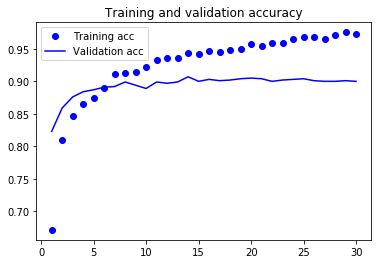

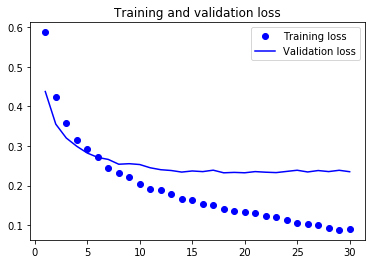

In [8]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### 数据增强

In [15]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))


model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


In [16]:
print('This is the number of trainable weights before freezing the conv base:',
      len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 4


In [17]:
conv_base.trainable = False

In [18]:
print('This is the number of trainable weights after freezing the conv base:',
      len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


### 训练与验证

In [19]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [20]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50,
    verbose=2)

Epoch 1/30
 - 19s - loss: 0.6150 - acc: 0.6725 - val_loss: 0.4844 - val_acc: 0.8100
Epoch 2/30
 - 18s - loss: 0.5033 - acc: 0.7775 - val_loss: 0.3905 - val_acc: 0.8470
Epoch 3/30
 - 18s - loss: 0.4478 - acc: 0.8065 - val_loss: 0.3489 - val_acc: 0.8700
Epoch 4/30
 - 18s - loss: 0.3961 - acc: 0.8250 - val_loss: 0.3178 - val_acc: 0.8750
Epoch 5/30
 - 17s - loss: 0.3949 - acc: 0.8295 - val_loss: 0.3065 - val_acc: 0.8770
Epoch 6/30
 - 17s - loss: 0.3809 - acc: 0.8375 - val_loss: 0.2900 - val_acc: 0.8830
Epoch 7/30
 - 17s - loss: 0.3598 - acc: 0.8425 - val_loss: 0.2891 - val_acc: 0.8800
Epoch 8/30
 - 17s - loss: 0.3639 - acc: 0.8395 - val_loss: 0.2810 - val_acc: 0.8860
Epoch 9/30
 - 17s - loss: 0.3548 - acc: 0.8480 - val_loss: 0.2699 - val_acc: 0.8880
Epoch 10/30
 - 17s - loss: 0.3476 - acc: 0.8495 - val_loss: 0.2640 - val_acc: 0.8950
Epoch 11/30
 - 17s - loss: 0.3426 - acc: 0.8485 - val_loss: 0.2636 - val_acc: 0.8960
Epoch 12/30
 - 18s - loss: 0.3355 - acc: 0.8560 - val_loss: 0.2576 - val_a

In [21]:
model.save('cats_and_dogs_small_3.h5')

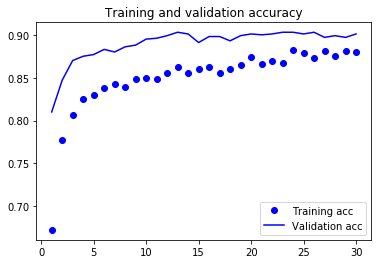

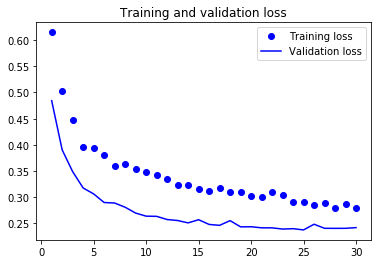

In [22]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### 微调

In [23]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [24]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/100
100/100 [==============================] - 19s 187ms/step - loss: 0.2891 - acc: 0.8740 - val_loss: 0.2193 - val_acc: 0.9020
Epoch 2/100
100/100 [==============================] - 18s 176ms/step - loss: 0.2636 - acc: 0.8885 - val_loss: 0.2138 - val_acc: 0.9110
Epoch 3/100
100/100 [==============================] - 18s 181ms/step - loss: 0.2288 - acc: 0.8975 - val_loss: 0.1937 - val_acc: 0.9180
Epoch 4/100
100/100 [==============================] - 18s 180ms/step - loss: 0.2238 - acc: 0.9015 - val_loss: 0.2329 - val_acc: 0.9120
Epoch 5/100
100/100 [==============================] - 18s 179ms/step - loss: 0.2173 - acc: 0.9130 - val_loss: 0.2122 - val_acc: 0.9130
Epoch 6/100
100/100 [==============================] - 18s 180ms/step - loss: 0.2059 - acc: 0.9165 - val_loss: 0.2139 - val_acc: 0.9230
Epoch 7/100
100/100 [==============================] - 18s 175ms/step - loss: 0.1824 - acc: 0.9255 - val_loss: 0.1721 - val_acc: 0.9340
Epoch 8/100
100/100 [===========================

Epoch 61/100
100/100 [==============================] - 18s 178ms/step - loss: 0.0312 - acc: 0.9895 - val_loss: 0.1905 - val_acc: 0.9390
Epoch 62/100
100/100 [==============================] - 18s 179ms/step - loss: 0.0389 - acc: 0.9870 - val_loss: 0.2426 - val_acc: 0.9300
Epoch 63/100
100/100 [==============================] - 18s 178ms/step - loss: 0.0241 - acc: 0.9910 - val_loss: 0.3322 - val_acc: 0.9220
Epoch 64/100
100/100 [==============================] - 18s 179ms/step - loss: 0.0369 - acc: 0.9895 - val_loss: 0.2170 - val_acc: 0.9370
Epoch 65/100
100/100 [==============================] - 18s 181ms/step - loss: 0.0253 - acc: 0.9905 - val_loss: 0.2998 - val_acc: 0.9250
Epoch 66/100
100/100 [==============================] - 18s 178ms/step - loss: 0.0283 - acc: 0.9900 - val_loss: 0.2954 - val_acc: 0.9270
Epoch 67/100
100/100 [==============================] - 18s 179ms/step - loss: 0.0330 - acc: 0.9895 - val_loss: 0.2292 - val_acc: 0.9380
Epoch 68/100
100/100 [===================

In [25]:
model.save('cats_and_dogs_small_4.h5')

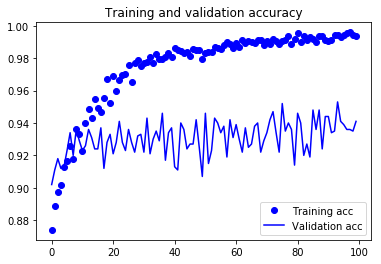

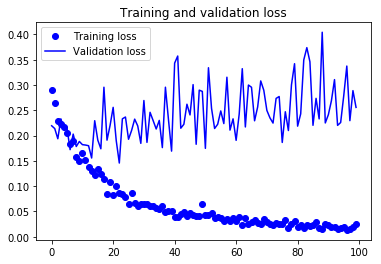

In [26]:

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

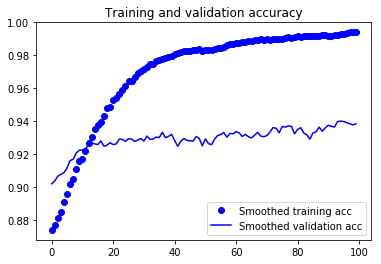

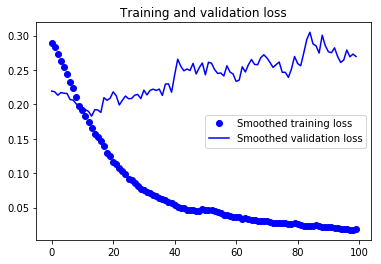

In [27]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [28]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.
test acc: 0.9349999952316285
